### Logistic Regression Model

In [1]:
# imports libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, 
                             roc_curve)
import warnings
import joblib
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
# load the preprocessed dataset
df = pd.read_csv("./datasets/logistic-regression.csv")
print("Dataset shape:", df.shape)
print("First 5 rows:")
df.head()

Dataset shape: (251562, 27)
First 5 rows:


,Country_Argentina,Country_Spain,Country_UK,Country_Canada,Country_Turkey,Country_USA,Country_Saudi Arabia,Country_France,Country_Australia,Country_South Korea,...,Country_Germany,Country_Indonesia,Country_Brazil,Employment_Status_Unemployed,Employment_Status_Retired,Smoking_Status_Former,Smoking_Status_Current,Employment_Status_Employed,Smoking_Status_Never,Hypertension
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1


In [3]:
# prepare features and target
X = df.drop('Hypertension', axis=1) # Features
y = df['Hypertension'] # Target

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training Data")
print(f"set shape: {X_train.shape}")
print(f"Class distribution: {y_train.value_counts()}")

print("\n")

print("Test Data")
print(f"shape: {X_test.shape}")
print(f"Class distribution: {y_test.value_counts()}")

Training Data
set shape: (201249, 26)
Class distribution: Hypertension
1    100625
0    100624
Name: count, dtype: int64


Test Data
shape: (50313, 26)
Class distribution: Hypertension
0    25157
1    25156
Name: count, dtype: int64


In [4]:
# Model 1: baseline (with all features)
baseline_lr = LogisticRegression(random_state=42, max_iter=1000)
baseline_lr.fit(X_train, y_train)

# evaluate baseline model
y_pred_baseline = baseline_lr.predict(X_test)
y_prob_baseline = baseline_lr.predict_proba(X_test)[:, 1]

# Calculate metrics
baseline_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline),
    'Recall': recall_score(y_test, y_pred_baseline),
    'F1 Score': f1_score(y_test, y_pred_baseline),
    'AUC-ROC': roc_auc_score(y_test, y_prob_baseline)
}

print("Baseline Logistic Regression Performance:")
for metric, value in baseline_metrics.items():
    print(f"{metric}: {value:.4f}")

Baseline Logistic Regression Performance:
Accuracy: 0.8017
Precision: 0.7160
Recall: 1.0000
F1 Score: 0.8345
AUC-ROC: 0.8003


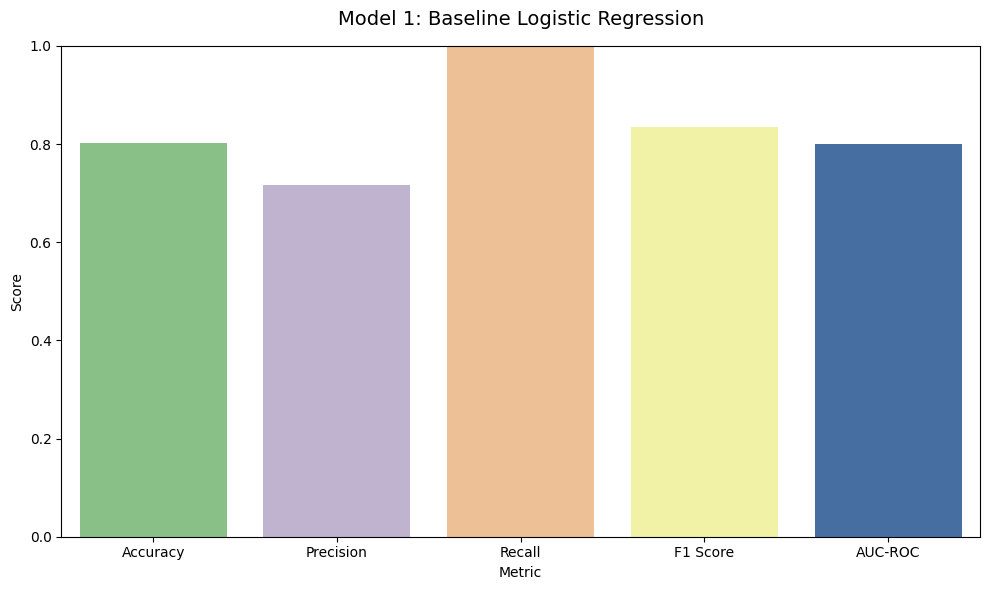

In [5]:
# Plot baseline metrics
plt.figure(figsize=(10, 6))
metrics_df = pd.DataFrame(list(baseline_metrics.items()), columns=['Metric', 'Score'])
sns.barplot(x='Metric', y='Score', data=metrics_df, palette='Accent')
plt.title('Model 1: Baseline Logistic Regression', fontsize=14, pad=15)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.tight_layout()
plt.savefig('./results/eda/logistic_regression_baseline_metrics.png')
plt.show()

In [6]:
# Save the baseline model
joblib.dump(baseline_lr, './results/models/logistic_regression_model_baseline.pkl')

['./results/models/logistic_regression_model_baseline.pkl']

In [7]:
# Model 2: tuned (with all features)
# Define parameter grid for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

cross_val = 5

lr = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cross_val,
    n_jobs=-1,
    verbose=1
)

# Sample from all features for tuning
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, train_size=50000, random_state=42
)

# Perform tuning
grid_search.fit(X_sample, y_sample)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Train model with best parameters
tuned_lr = LogisticRegression(**grid_search.best_params_, random_state=42)
tuned_lr.fit(X_train, y_train)

# Evaluate the tuned model
y_pred_tuned = tuned_lr.predict(X_test)
y_prob_tuned = tuned_lr.predict_proba(X_test)[:, 1]

# Calculate metrics
tuned_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1 Score': f1_score(y_test, y_pred_tuned),
    'AUC-ROC': roc_auc_score(y_test, y_prob_tuned)
}

print("\nTuned Logistic Regression Performance:")
for metric, value in tuned_metrics.items():
    print(f"{metric}: {value:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters found by GridSearchCV:
{'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

Tuned Logistic Regression Performance:
Accuracy: 0.8017
Precision: 0.7160
Recall: 1.0000
F1 Score: 0.8345
AUC-ROC: 0.8002


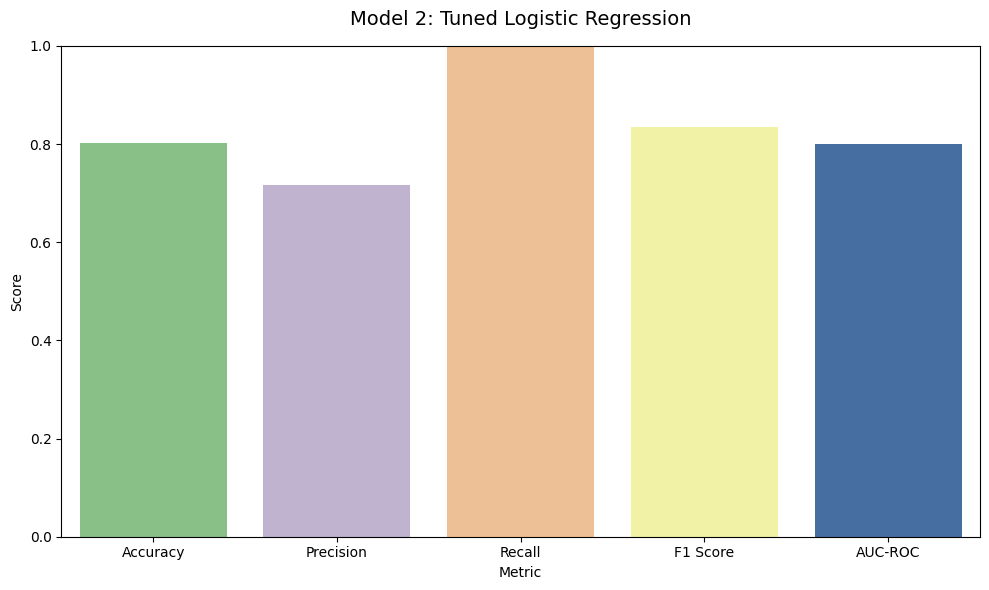

In [8]:
# Plot tuned metrics
plt.figure(figsize=(10, 6))
metrics_df = pd.DataFrame(list(tuned_metrics.items()), columns=['Metric', 'Score'])
sns.barplot(x='Metric', y='Score', data=metrics_df, palette='Accent')
plt.title('Model 2: Tuned Logistic Regression', fontsize=14, pad=15)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.tight_layout()
plt.savefig('./results/eda/logistic_regression_tuned_metrics.png')
plt.show()

Comparison: Baseline vs Tuned
      Metric  Baseline     Tuned
0   Accuracy  0.801721  0.801721
1  Precision  0.716042  0.716042
2     Recall  1.000000  1.000000
3   F1 Score  0.834528  0.834528
4    AUC-ROC  0.800341  0.800249


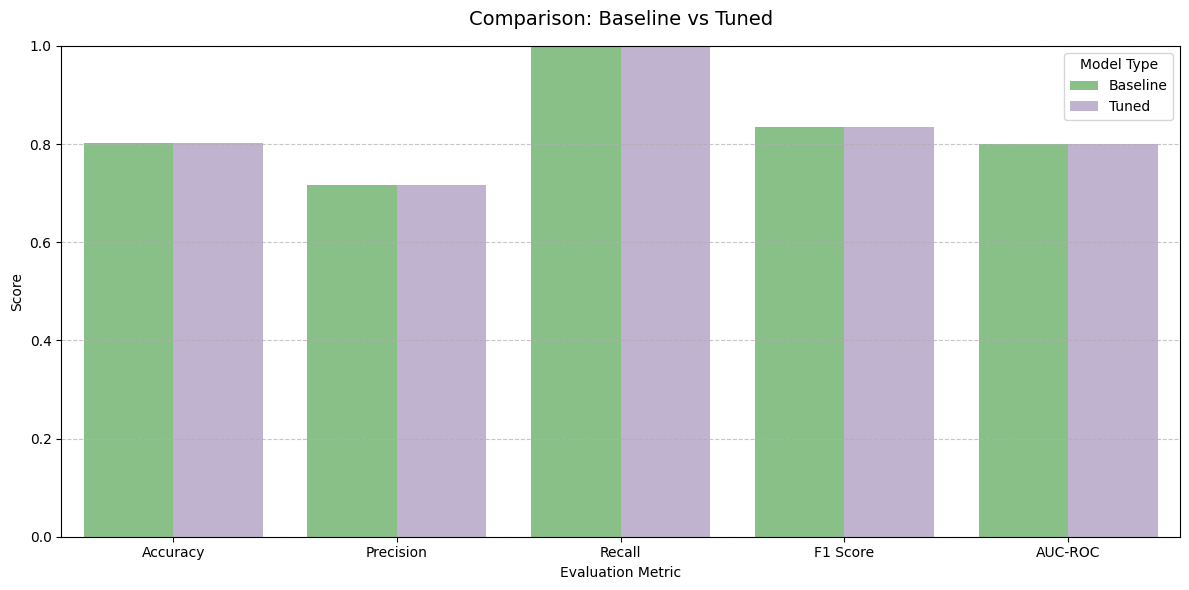

In [9]:
# Comparison: baseline vs tuned
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
    'Baseline': [
        baseline_metrics['Accuracy'],
        baseline_metrics['Precision'],
        baseline_metrics['Recall'],
        baseline_metrics['F1 Score'],
        baseline_metrics['AUC-ROC']
    ],
    'Tuned': [
        tuned_metrics['Accuracy'],
        tuned_metrics['Precision'],
        tuned_metrics['Recall'],
        tuned_metrics['F1 Score'],
        tuned_metrics['AUC-ROC']
    ]
})

print("Comparison: Baseline vs Tuned")
print(comparison)

# Plot comparison
plt.figure(figsize=(12, 6))
comparison_melted = comparison.melt(id_vars='Metric', var_name='Model', value_name='Score')
sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Model', palette='Accent')
plt.title('Comparison: Baseline vs Tuned', fontsize=14, pad=15)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Evaluation Metric')
plt.legend(title='Model Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./results/eda/logistic_regression_comparison.png')
plt.show()

In [10]:
# Function to evaluate underfitting/overfitting
def evaluate_model_fit(model, X_train, y_train, X_test, y_test, model_name):
    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate accuracies
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    # Calculate overfitting gap
    gap = train_acc - test_acc
    
    # Determine fit status
    if gap > 0.15:
        status = "Overfitting"
    elif train_acc < 0.7 and test_acc < 0.7:
        status = "Underfitting"
    else:
        status = "Good Fit"
    
    # Create results dataframe
    results = pd.DataFrame({
        'Model': [model_name],
        'Training Accuracy': [train_acc],
        'Test Accuracy': [test_acc],
        'Gap': [gap],
        'Status': [status]
    })
    
    return results

In [11]:
# Evaluate baseline model fit
baseline_fit = evaluate_model_fit(
    baseline_lr, X_train, y_train, X_test, y_test, 
    "Baseline Logistic Regression"
)
print("Baseline Model Fit Analysis:")
print(baseline_fit)

Baseline Model Fit Analysis:
                          Model  Training Accuracy  Test Accuracy       Gap  \
0  Baseline Logistic Regression           0.802931       0.801721  0.001209   

     Status  
0  Good Fit  


In [12]:
# Evaluate tuned model fit
tuned_fit = evaluate_model_fit(
    tuned_lr, X_train, y_train, X_test, y_test, 
    "Tuned Logistic Regression"
)
print("\nTuned Model Fit Analysis:")
print(tuned_fit)


Tuned Model Fit Analysis:
                       Model  Training Accuracy  Test Accuracy       Gap  \
0  Tuned Logistic Regression           0.802931       0.801721  0.001209   

     Status  
0  Good Fit  


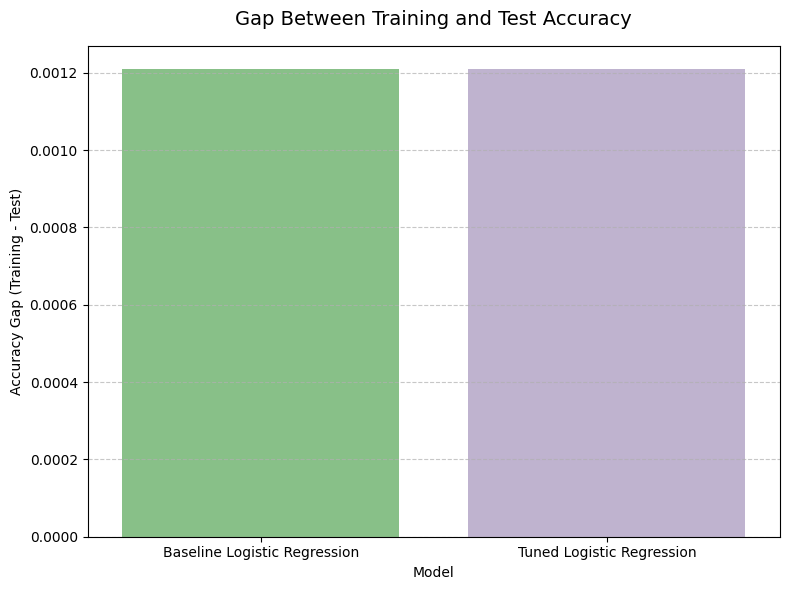

In [13]:
# Simple gap visualization between training and test accuracy
fit_results = pd.concat([baseline_fit, tuned_fit], ignore_index=True)

# Create a simple bar chart showing the gap
plt.figure(figsize=(8, 6))
sns.barplot(data=fit_results, x='Model', y='Gap', palette='Accent')
plt.title('Gap Between Training and Test Accuracy', fontsize=14, pad=15)
plt.ylabel('Accuracy Gap (Training - Test)')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./results/eda/logistic_regression_simple_gap.png')
plt.show()

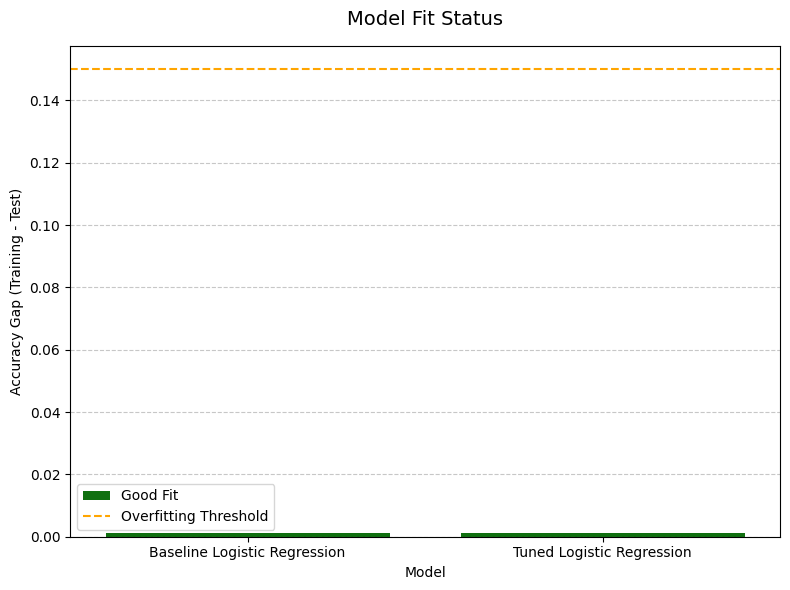

In [14]:
# Simple fit status visualization
plt.figure(figsize=(8, 6))

# Create a bar plot with status colors
status_colors = {'Good Fit': 'green', 'Overfitting': 'red', 'Underfitting': 'blue'}
sns.barplot(data=fit_results, x='Model', y='Gap', hue='Status', 
            palette=status_colors, dodge=False)

# Add threshold line
plt.axhline(y=0.15, color='orange', linestyle='--', label='Overfitting Threshold')

plt.title('Model Fit Status', fontsize=14, pad=15)
plt.ylabel('Accuracy Gap (Training - Test)')
plt.xlabel('Model')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./results/eda/logistic_regression_fit_status.png')
plt.show()

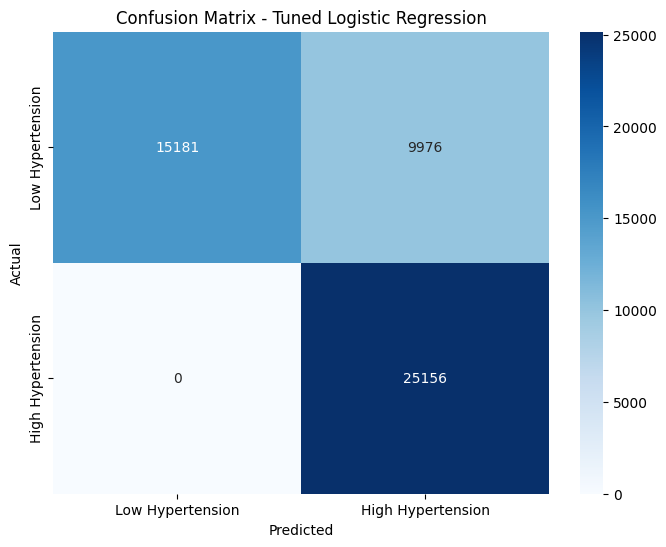

In [15]:
# Confusion Matrix for Tuned Model
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Hypertension', 'High Hypertension'],
            yticklabels=['Low Hypertension', 'High Hypertension'])
plt.title('Confusion Matrix - Tuned Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('./results/eda/logistic_regression_confusion_matrix.png')
plt.show()

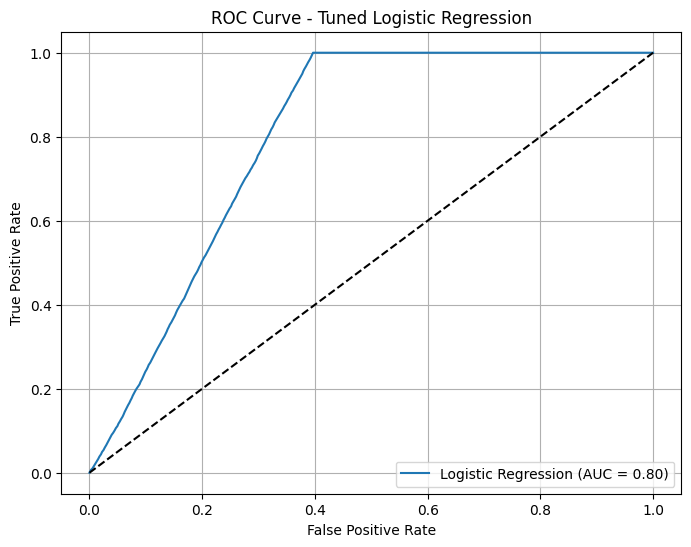

In [16]:
# ROC Curve for Tuned Model
fpr, tpr, thresholds = roc_curve(y_test, y_prob_tuned)
auc_score = roc_auc_score(y_test, y_prob_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Logistic Regression')
plt.legend()
plt.grid(True)
plt.savefig('./results/eda/logistic_regression_roc_curve.png')
plt.show()

In [17]:
# save evaluation details
model_name = "Logistic Regression" 

# create data frame for this model's metrics
model_metrics = pd.DataFrame({
    'Model': [
        f'{model_name} - Baseline', 
        f'{model_name} - Tuned'
    ],
    'Accuracy': [
        baseline_metrics['Accuracy'],
        tuned_metrics['Accuracy']
    ],
    'Precision': [
        baseline_metrics['Precision'],
        tuned_metrics['Precision']
    ],
    'Recall': [
        baseline_metrics['Recall'],
        tuned_metrics['Recall']
    ],
    'F1_Score': [
        baseline_metrics['F1 Score'],
        tuned_metrics['F1 Score']
    ],
    'AUC_ROC': [
        baseline_metrics['AUC-ROC'],
        tuned_metrics['AUC-ROC']
    ]
})

#  save model details
model_metrics.to_csv(f'./results/metrics/{model_name.lower().replace(" ", "_")}.csv', index=False)

In [18]:
# Save the tuned model
joblib.dump(tuned_lr, './results/models/logistic_regression_model_tuned.pkl')

print("Completed...!")

Completed...!
